## Dimensionality reduction with PCA and t-SNE
## Using RAPIDS / CUDA for accelerating t-SNE

In [1]:
import numpy as np
import pandas as pd

import cudf
import cuml
from cuml.manifold import TSNE

from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline


### import MNIST data from openml

In [2]:
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
np.shape(X_mnist)

(70000, 784)

In [134]:
def pca(X,y,dim=50, scale = True):
    pca = PCA(n_components=dim)
    print(np.shape(X))
    X = np.c_[X,y]
    print(np.shape(X))
    scaler = StandardScaler()
    if scale:
        X = scaler.fit_transform(X)
    result = pca.fit_transform(X)
    return result

def tsne(X,n_components = 2,perplexity=40,n_iter=5000,learning_rate=100):
    tsne = TSNE(n_components = n_components, verbose=1,perplexity=perplexity,n_iter=n_iter, learning_rate=learning_rate)
    X_hat = tsne.fit_transform(X)
    return X_hat

In [135]:
#Reduce Dimensionality to 50 first
mnist_pca = pca(X_mnist,y_mnist,dim=30, scale=True)

(70000, 784)
(70000, 785)


In [136]:
mnist_tsne = tsne(mnist_pca, perplexity=50, n_iter=5000, learning_rate=200)

Learning rate is adaptive. In TSNE paper, it has been shown that as n->inf, Barnes Hut works well if n_neighbors->30, learning_rate->20000, early_exaggeration->24.
cuML uses an adpative method.n_neighbors decreases to 30 as n->inf. Likewise for the other params.
New n_neighbors = 30, learning_rate = 23333.333333333332, exaggeration = 24.0


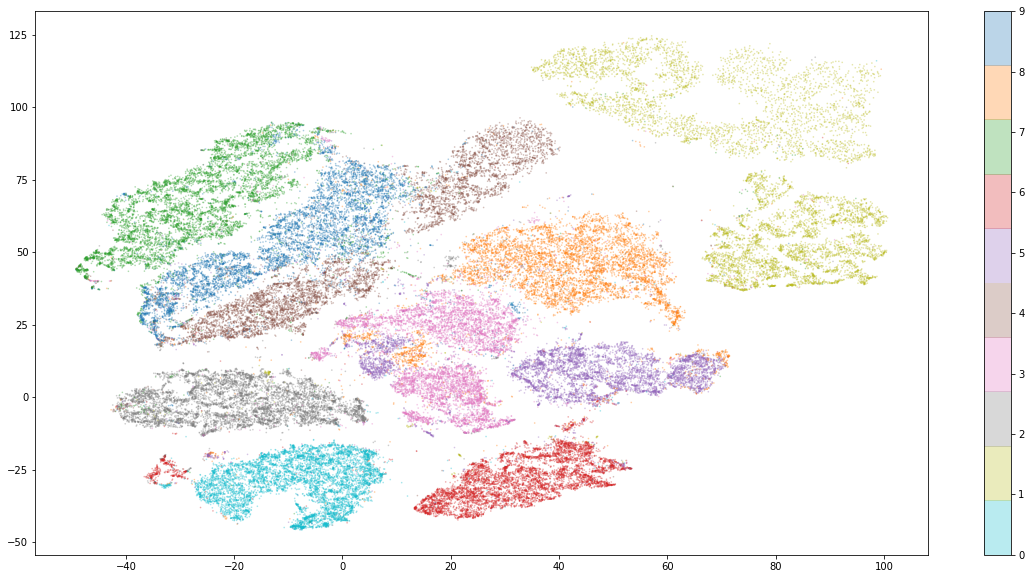

In [137]:
plot_fig = plt.figure(figsize=(20,10))
plt.scatter(mnist_tsne[:,0], mnist_tsne[:,1], c = y_mnist.astype(int), s = 0.5,alpha=0.3, cmap=plt.cm.tab10_r)
plt.colorbar()

In [8]:
X_cifar, y_cifar = fetch_openml('CIFAR_10_small', version=1, return_X_y=True)

In [9]:
np.shape(X_cifar)

(20000, 3072)

In [10]:
#Reduce Dimensionality to 30 first
cifar_pca = pca(X_cifar,y_cifar,dim=30,scale=True)

(20000, 3072)
(20000, 3073)


In [11]:
cifar_tsne = tsne(cifar_pca,n_iter=10000,learning_rate=200, perplexity=50)

Learning rate is adaptive. In TSNE paper, it has been shown that as n->inf, Barnes Hut works well if n_neighbors->30, learning_rate->20000, early_exaggeration->24.
cuML uses an adpative method.n_neighbors decreases to 30 as n->inf. Likewise for the other params.
New n_neighbors = 78, learning_rate = 6666.666666666666, exaggeration = 24.0


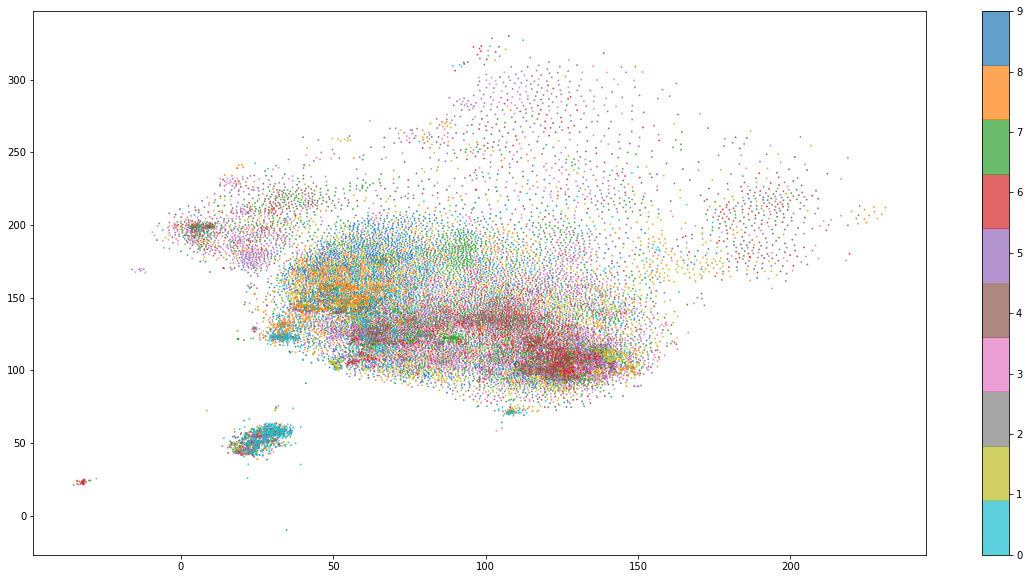

In [12]:
plot_fig = plt.figure(figsize=(20,10))
plt.scatter(cifar_tsne[:,0], cifar_tsne[:,1], c = y_cifar.astype(int), s = 0.9,alpha=0.7, cmap=plt.cm.tab10_r)
plt.colorbar()

In [102]:
X_dating, y_dating = fetch_openml('SpeedDating', version=1, return_X_y=True)

In [103]:
np.shape(X_dating)

(8378, 120)

In [108]:
X_dating = np.nan_to_num(X_dating,nan=-99)

In [109]:
dating_pca = pca(X_dating,y_dating,dim=50, scale=True)

(8378, 120)
(8378, 121)


In [118]:
dating_tsne = tsne(dating_pca,n_iter=5000,learning_rate=150, perplexity=40)

Learning rate is adaptive. In TSNE paper, it has been shown that as n->inf, Barnes Hut works well if n_neighbors->30, learning_rate->20000, early_exaggeration->24.
cuML uses an adpative method.n_neighbors decreases to 30 as n->inf. Likewise for the other params.
New n_neighbors = 91, learning_rate = 2792.6666666666665, exaggeration = 12.0


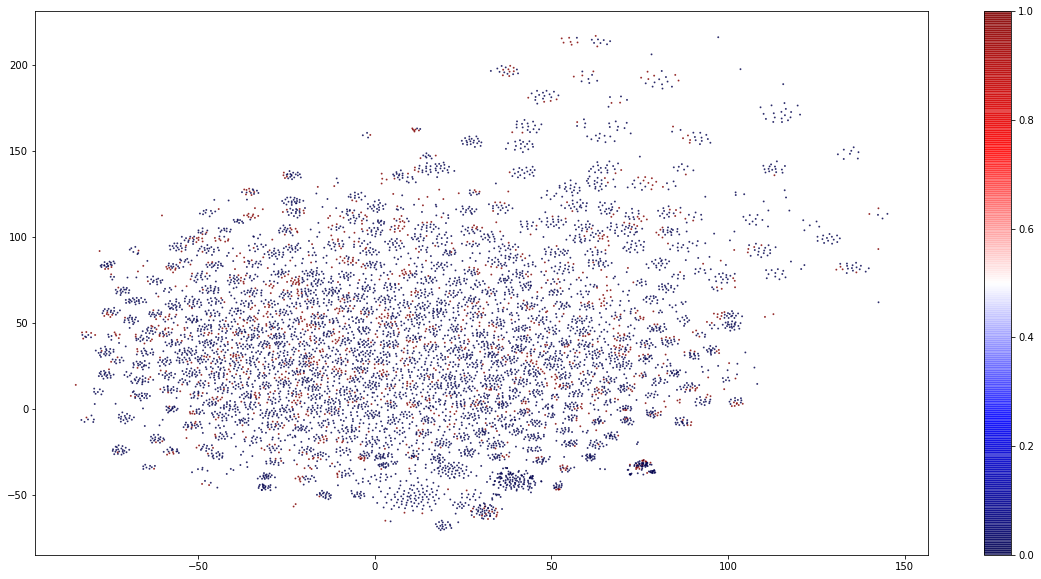

In [119]:
plot_fig = plt.figure(figsize=(20,10))
plt.scatter(dating_tsne[:,0], dating_tsne[:,1], c = y_dating.astype(int), s = 0.9,alpha=0.7, cmap='seismic')
plt.colorbar()

In [122]:
X_zurich, y_zurich = fetch_openml('delays_zurich_transport', version=1, return_X_y=True, as_frame=True)

In [123]:
le = preprocessing.LabelEncoder()

In [124]:
X_zurich['vehicle_type_enc'] = le.fit_transform(X_zurich['vehicle_type'].apply(str))
X_zurich['line_number_enc'] = le.fit_transform(X_zurich['line_number'].apply(str))
X_zurich['time'] = pd.to_datetime(X_zurich['time'])
tmp = pd.DataFrame(X_zurich['time'].values.astype(float))
tmp = tmp / tmp.max()
tmp = preprocessing.scale(tmp)
X_zurich['time_scaled'] = pd.DataFrame(tmp)
X_zurich['weekday'] = X_zurich['weekday'].astype(int)
X_zurich['delay'] = y_zurich
X_zurich=X_zurich.drop(['vehicle_type','line_number','time'], axis=1)

In [125]:
np.shape(X_zurich)

(5465575, 15)

In [129]:
reduced_data = X_zurich.sample(np.shape(X_zurich)[0]//20) #Data had to be reduced du to memory limitations
reduced_data['delay'].clip(-500,500); # clip the data to handle outliners

In [131]:
np.shape(reduced_data)

(273278, 15)

In [132]:
#PCA is not need since we have just 14 features 
zurich_tsne = tsne(np.array(reduced_data),n_iter=5000,learning_rate=150, perplexity=80)

Learning rate is adaptive. In TSNE paper, it has been shown that as n->inf, Barnes Hut works well if n_neighbors->30, learning_rate->20000, early_exaggeration->24.
cuML uses an adpative method.n_neighbors decreases to 30 as n->inf. Likewise for the other params.
New n_neighbors = 30, learning_rate = 91092.66666666666, exaggeration = 24.0


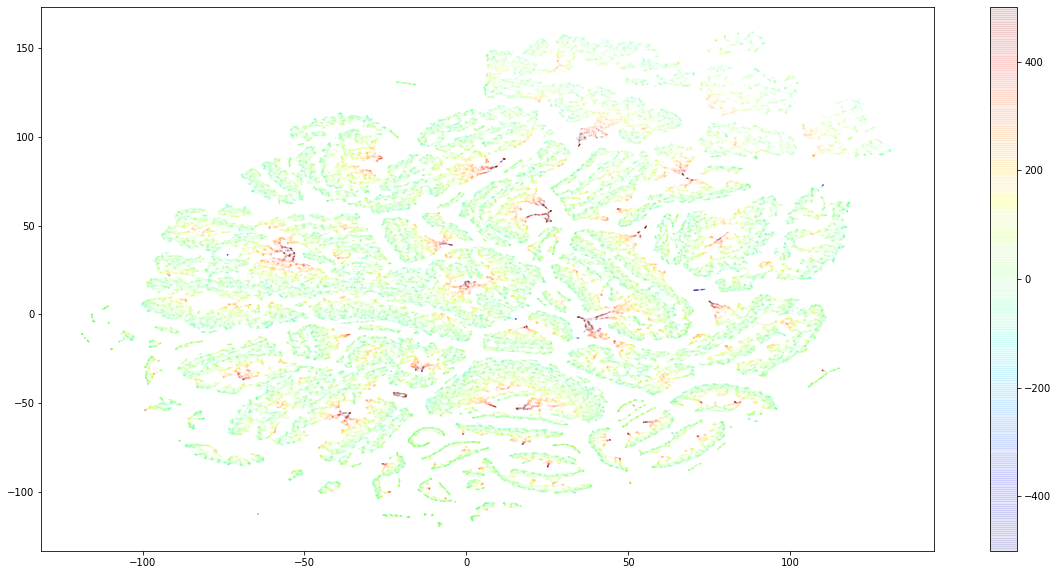

In [133]:
plot_fig = plt.figure(figsize=(20,10))
plt.scatter(zurich_tsne[:,0], zurich_tsne[:,1], c = reduced_data['delay'].clip(-500,500).astype(float), s = 0.1,alpha=0.1,cmap='jet')
plt.colorbar()